In [ ]:
!pip install scanpy
# this is a package for single cell RNA-seq analysis

# Example 1: Clustering

## Load and Explore the data

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import scanpy as sc

# Load the PBMC 3k dataset (returns an AnnData object)
adata = sc.datasets.pbmc3k()  # Automatically downloads and caches the dataset
X = adata.X.toarray()         # Convert sparse matrix to a dense NumPy array (cells × genes)

In [26]:
# get some look at the data X

print(X.shape) 

# print ratio of non-zero elements, from which we can see that the data is very sparse
print("Ratio of non-zero elements: ", np.count_nonzero(X) / X.size)


(2700, 32738)
Ratio of non-zero elements:  0.025871894253591363


## Perform EM as in section 4.2

Final means (mu):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Final mixing coefficients (pi):
[0.73962963 0.17777778 0.08259259]


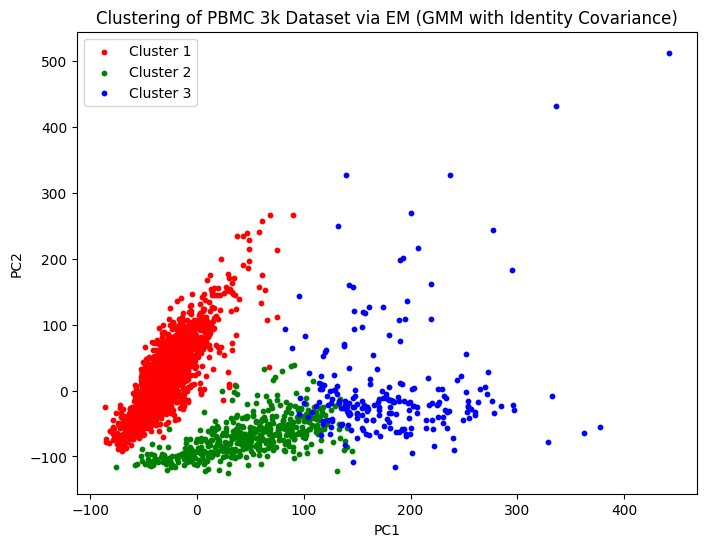

In [ ]:
# Set parameters for EM
N, d = X.shape
K = 3          # Number of clusters (can be adjusted)
max_iter = 100
tol = 1e-4

# Initialize parameters:
# Randomly choose K points as initial means
np.random.seed(0)
initial_indices = np.random.choice(N, K, replace=False)
mu = X[initial_indices]  # shape: (K, d)
pi = np.full(K, 1.0/K)   # Uniform mixing coefficients

# Identity covariance is assumed for all clusters.
# Thus, the Gaussian density for a data point x given cluster k is:
# N(x | mu_k, I) = exp(-0.5*||x-mu_k||^2) / (2*pi)^(d/2)

# EM Algorithm
for iteration in range(max_iter):
    # # E-step: compute responsibilities gamma_{nk}
    # gamma = np.zeros((N, K))
    # for k in range(K):
    #     diff = X - mu[k]  # shape: (N, d)
    #     # Compute density for all points under cluster k:
    #     pdf = np.exp(-0.5 * np.sum(diff**2, axis=1)) / ((2*np.pi)**(d/2))
    #     gamma[:, k] = pi[k] * pdf
    # # Normalize responsibilities for each data point
    # gamma = gamma / gamma.sum(axis=1, keepdims=True)

    # Directly compute pdf causes numerical instability!

    # E-step: compute responsibilities gamma_{nk} using log-domain computations for stability
    # We use log scale
    log_gamma = np.zeros((N, K))
    for k in range(K):
        diff = X - mu[k]  # shape: (N, d)
        # Compute log-density for all points under cluster k:
        # log N(x|mu, I) = -0.5 * ||x - mu||^2 - (d/2)*log(2*pi)
        log_pdf = -0.5 * np.sum(diff**2, axis=1) - (d/2) * np.log(2 * np.pi)
        log_gamma[:, k] = np.log(pi[k]) + log_pdf

    # Use the log-sum-exp trick to normalize
    max_log_gamma = np.max(log_gamma, axis=1, keepdims=True)
    log_gamma_norm = log_gamma - max_log_gamma  # subtract maximum for stability
    gamma = np.exp(log_gamma_norm)
    gamma = gamma / np.sum(gamma, axis=1, keepdims=True)
    
    # M-step: update parameters mu and pi
    mu_new = np.zeros_like(mu)
    pi_new = np.zeros_like(pi)
    for k in range(K):
        Nk = np.sum(gamma[:, k])
        mu_new[k] = np.sum(gamma[:, k].reshape(-1, 1) * X, axis=0) / Nk
        pi_new[k] = Nk / N
    # Check convergence: if change in mu is small, break
    if np.linalg.norm(mu_new - mu) < tol:
        mu, pi = mu_new, pi_new
        break
    mu, pi = mu_new, pi_new

print("Final means (mu):")
print(mu)
print("Final mixing coefficients (pi):")
print(pi)

# After convergence, compute final responsibilities (posterior probabilities)
gamma_final = np.zeros((N, K))
log_gamma = np.zeros((N, K))
# for k in range(K):
#     diff = X - mu[k]
#     pdf = np.exp(-0.5 * np.sum(diff**2, axis=1)) / ((2*np.pi)**(d/2))
#     gamma_final[:, k] = pi[k] * pdf
# gamma_final = gamma_final / gamma_final.sum(axis=1, keepdims=True)
for k in range(K):
    diff = X - mu[k]
    log_pdf = -0.5 * np.sum(diff**2, axis=1) - (d/2) * np.log(2 * np.pi)
    log_gamma[:, k] = np.log(pi[k]) + log_pdf
max_log_gamma = np.max(log_gamma, axis=1, keepdims=True)
log_gamma_norm = log_gamma - max_log_gamma
gamma_final = np.exp(log_gamma_norm)
gamma_final = gamma_final / np.sum(gamma_final, axis=1, keepdims=True)

# Predict class label for each data point by taking the argmax of the posterior responsibilities
labels = np.argmax(gamma_final, axis=1)

# Dimensionality reduction: PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the clustering result
plt.figure(figsize=(8,6))
colors = ['red', 'green', 'blue']
for k in range(K):
    plt.scatter(X_pca[labels == k, 0], X_pca[labels == k, 1],
                color=colors[k], label=f'Cluster {k+1}', s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clustering of PBMC 3k Dataset via EM (GMM with Identity Covariance)")
plt.legend()
plt.show()

## Compare EM result with K-means

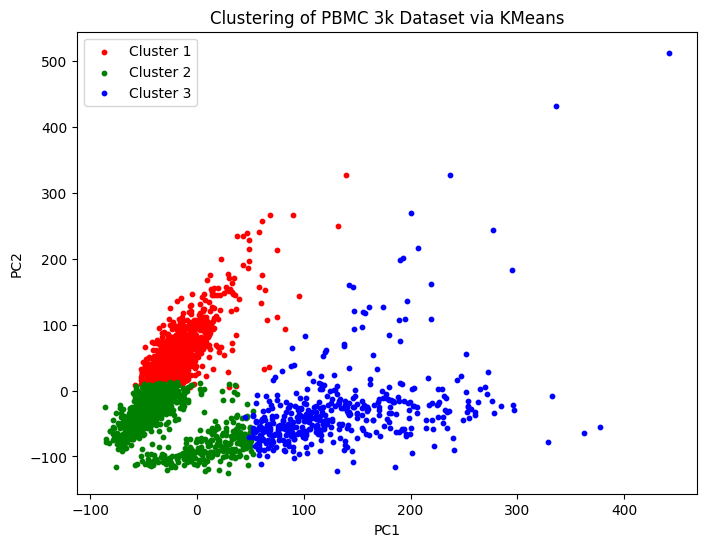

In [22]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k)
labels = kmeans.fit_predict(X)

# Plot the clustering result for k-means
plt.figure(figsize=(8,6))
colors = ['red', 'green', 'blue']
for k in range(K):
    plt.scatter(X_pca[labels == k, 0], X_pca[labels == k, 1],
                color=colors[k], label=f'Cluster {k+1}', s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clustering of PBMC 3k Dataset via KMeans")
plt.legend()
plt.show()

# Example 2: Missing Data

The proper real-world dataset and the general EM algorithm for this is still TODO. \\
We first illustrate the basic idea via a simple artificial data.

In [29]:
def EM(df, mu_x, mu_y, sigma_x, sigma_y, rho, threshold=1e-8, max_iter=100):
    '''EM algorithm for bivariate normal distribution with missing values.

    Input:
    df: pandas DataFrame with columns 'x' and 'y', containing missing values
    mu_x, mu_y: initial guess of the means
    sigma_x, sigma_y: initial guess of the standard deviations
    rho: initial guess of the correlation coefficient
    threshold: convergence threshold
    max_iter: maximum number of iterations

    Output:
    Dictionary containing the estimated parameters:
    - mu_x, mu_y: means
    - sigma_x, sigma_y: standard deviations
    - rho: correlation coefficient
    
    '''
    diff = 1
    for i in range(max_iter):
        df_first_moment = df.copy()
        df_second_moment = df.copy()**2
        # E step
        # compute expected x and y (first moment)
        for k, row in df_first_moment.iterrows():
            if np.isnan(row['x']):
                row['x'] = mu_x + sigma_x * rho * (row['y'] - mu_y) / sigma_y
            if np.isnan(row['y']):
                row['y'] = mu_y + sigma_y * rho * (row['x'] - mu_x) / sigma_x
        # compute expected x^2 and y^2 (second moment)
        for k, row in df_second_moment.iterrows():
            if np.isnan(row['x']):
                row['x'] = df_first_moment.loc[k, 'x']**2 + (sigma_x**2) * (1 - rho**2)
            if np.isnan(row['y']):
                row['y'] = df_first_moment.loc[k, 'y']**2 + (sigma_y**2) * (1 - rho**2)
        # M step
        # moment matching
        mu_x_new = df_first_moment['x'].mean()
        mu_y_new = df_first_moment['y'].mean()
        sigma_x_new = np.sqrt(df_second_moment['x'].mean() - mu_x_new**2)
        sigma_y_new = np.sqrt(df_second_moment['y'].mean() - mu_y_new**2)
        rho_new = ((df_first_moment['x'] - mu_x_new) * (df_first_moment['y'] - mu_y_new)).mean() / (sigma_x_new * sigma_y_new)
        # compute difference
        diff = np.abs(mu_x_new - mu_x) + np.abs(mu_y_new - mu_y) + np.abs(sigma_x_new - sigma_x) + np.abs(sigma_y_new - sigma_y) + np.abs(rho_new - rho)
        # update parameters
        mu_x = mu_x_new
        mu_y = mu_y_new
        sigma_x = sigma_x_new
        sigma_y = sigma_y_new
        rho = rho_new
        # check convergence
        if diff < threshold:
            # print('EM converged after {} iterations'.format(i))
            break
    return {'mu_x': mu_x, 'mu_y': mu_y, 'sigma_x': sigma_x, 'sigma_y': sigma_y, 'rho': rho}

In [31]:
# Now simulate some data

def sim2norm(n,mean,cov,f):
    '''
    Simulate data from a bivariate normal distribution with missing values.
    
    Input:
    n: number of samples
    mean: mean vector
    cov: covariance matrix
    f: fraction of missing values

    Output:
    Two pandas DataFrames:
    - one with the observed data
    - one with the data with missing
    '''
    x = np.random.multivariate_normal(mean, cov, n)
    x_observed = x.copy()
    have_missing = np.random.binomial(1, f, len(x)).astype(bool)
    for i in range(len(x)):
        if have_missing[i]:
            if np.random.binomial(1, 0.5):
                x[i][0] = np.nan
            else:
                x[i][1] = np.nan
    return pd.DataFrame(x_observed, columns=['x', 'y']), pd.DataFrame(x, columns=['x', 'y'])

# Set parameters for the simulation
n = 1000
mean = [2, 4]
cov = [[9, 1.5], [1.5, 1]] 
f = 0.3

# Simulate data
df_observed, df = sim2norm(n, mean, cov, f)

# Initial guess of the parameters
mu_x = df['x'].mean()
mu_y = df['y'].mean()
sigma_x = df['x'].std()
sigma_y = df['y'].std()
rho = 0

# Run EM algorithm
result = EM(df, mu_x, mu_y, sigma_x, sigma_y, rho)
print('Estimated parameters:')
print(f"estimated mu ({result['mu_x']}, {result['mu_y']})")
print(f"estimated sigma ({result['sigma_x']}, {result['sigma_y']})")
print(f"estimated rho {result['rho']}")
print('True parameters:')
print(f"true mu ({mean[0]}, {mean[1]})")
print(f"true sigma ({np.sqrt(cov[0][0]), np.sqrt(cov[1][1])})")
print(f"true rho {cov[0][1] / (np.sqrt(cov[0][0]) * np.sqrt(cov[1][1]))}")


Estimated parameters:
estimated mu (2.0125596899541915, 4.0166329351286)
estimated sigma (3.065712620602321, 0.9865435929174209)
estimated rho 0.49299643546578004
True parameters:
true mu (2, 4)
true sigma ((np.float64(3.0), np.float64(1.0)))
true rho 0.5
